In [1]:
import numpy as np
from numpy.linalg import cholesky


In [2]:
def log_gaussian(x, mean, cov):
    d = len(x)
    L = cholesky(cov)
    diff = x - mean
    sol = np.linalg.solve(L, diff)
    return -0.5 * np.dot(sol, sol) - np.sum(np.log(np.diag(L))) - 0.5 * d * np.log(2*np.pi)

def simulate_lgssm(A, H, Q, R, x0, T):
    d_x = len(x0)
    d_y = H.shape[0]
    X = np.zeros((T+1, d_x))
    Y = np.zeros((T,d_y))

    X[0] = x0
    for k in range(T):
        X[k+1] = A @ X[k] + np.random.multivariate_normal(np.zeros(d_x), Q)
        Y[k] = H @ X[k+1] + np.random.multivariate_normal(np.zeros(d_y), R)

    return X, Y

A = np.array([[1,0.1],[-0.1,1]])
H = np.eye(2)
Q = 0.000*np.eye(2)
R = 0.000001*np.eye(2)
x0 = np.array([[1],[1]]).reshape((2,))
T = 5

X, Y = simulate_lgssm(A, H, Q, R, x0, T)

X, Y


(array([[1.     , 1.     ],
        [1.1    , 0.9    ],
        [1.19   , 0.79   ],
        [1.269  , 0.671  ],
        [1.3361 , 0.5441 ],
        [1.39051, 0.41049]]),
 array([[1.09991338, 0.89962937],
        [1.19038538, 0.78914582],
        [1.27032572, 0.67059765],
        [1.33521814, 0.54435462],
        [1.38983831, 0.41070403]]))

In [7]:
from tqdm import tqdm 

def MHMCfilter_linear(Y, m0, P0, A, H, Q, R, S, N=1000):
    d_x = A.shape[0]
    d_y = H.shape[0]
    T = Y.shape[0]
    samples_e = np.zeros((N, T+1, d_x))
    samples_o = np.zeros((N, T+1, d_x))

    def log_predictive(x, samples_o_t, A, Q):
        logs = np.array([
            log_gaussian(x, A @ samples_o_t[i], Q)
            for i in range(samples_o_t.shape[0])
        ])
        m = np.max(logs)
        return m + np.log(np.mean(np.exp(logs - m)))



    # Inicializar la cadena de Markov
    samples_e[0,0] = np.random.multivariate_normal(m0, P0)
    samples_o[0,0] = np.random.multivariate_normal(m0, P0)
    for t in range(T):
        ## Evolución
        xt_samples = samples_o[:,t,:]
        for s in range(N):
            m_t = A @ xt_samples[s]
            samples_e[s,t+1,:] = np.random.multivariate_normal(m_t, Q)
        ## Predicción
        y = Y[t]

        for s in tqdm(range(N),desc=f"Tiempo {t}/{T}"):
            x = samples_e[s,t+1,:]
            ll_current = log_gaussian(y, H @ x, R)
            lp_current = log_predictive(x, samples_o[:,t,:], A, Q)

            samples_mh = np.zeros((N, d_x))
            for l in range(N):
                # Propuesta
                x_prop = np.random.multivariate_normal(x, S)
                # Cálculo de la aceptación
                ll_proposed = log_gaussian(y, H @ x_prop, R)
                lp_proposed = log_predictive(x_prop, samples_o[:,t,:], A, Q)
                log_alpha = (ll_proposed + lp_proposed) - (ll_current + lp_current)
                if np.log(np.random.uniform()) < log_alpha: # Aceptación
                    samples_mh[l,:] = x_prop
                    ll_current = ll_proposed
                    lp_current = lp_proposed
                else: # Rechazo
                    samples_mh[l,:] = x
            # Actualizar la cadena de Markov
            samples_o[s,t+1,:] = samples_mh[-1,:]

    return samples_e, samples_o

##############################################################

A = np.array([[1.05]])
H = np.eye(1)
Q = 0.001*np.eye(1)
R = 0.1*np.eye(1)
x0 = np.array([[1]]).reshape((1,))
T = 5

X, Y = simulate_lgssm(A, H, Q, R, x0, T)


results = MHMCfilter_linear(Y, x0, 0.001*np.eye(1), A, H, Q, R, 0.1*np.eye(1),100)

Tiempo 4/5: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


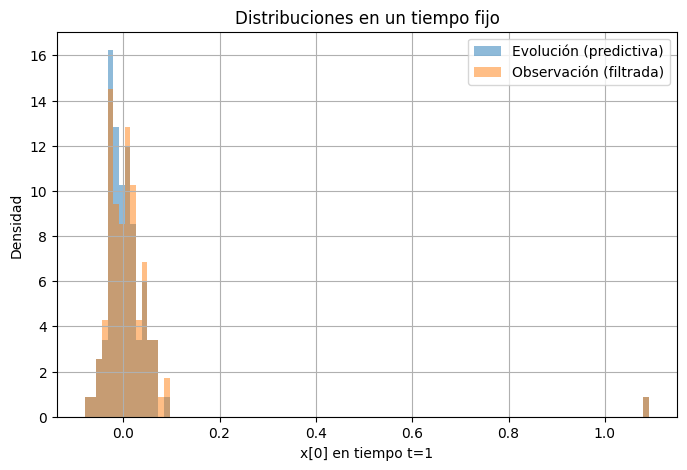

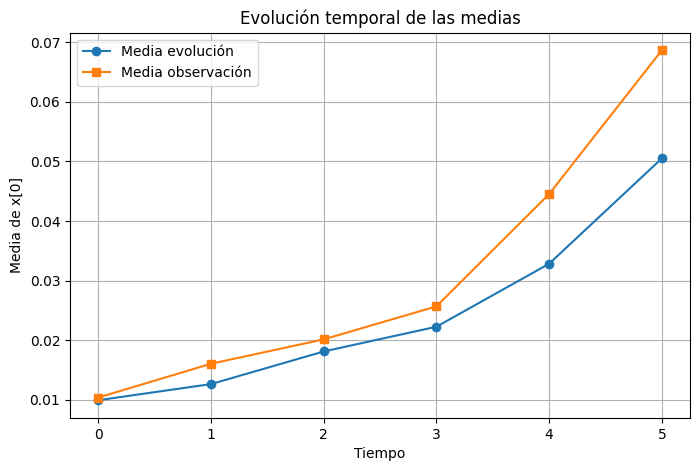

In [13]:
import matplotlib.pyplot as plt

def plot_hist_evolution_observation(samples_e, samples_o, t, dim=0, bins=100):
    """
    Histogramas de:
    - distribución predictiva (evolución)
    - distribución filtrada (observación)
    en un tiempo fijo t y dimensión dim
    """
    x_e = samples_e[:, t, dim]
    x_o = samples_o[:, t, dim]

    plt.figure(figsize=(8,5))
    plt.hist(x_e, bins=bins, density=True, alpha=0.5, label="Evolución (predictiva)")
    plt.hist(x_o, bins=bins, density=True, alpha=0.5, label="Observación (filtrada)")
    plt.xlabel(f"x[{dim}] en tiempo t={t}")
    plt.ylabel("Densidad")
    plt.legend()
    plt.title("Distribuciones en un tiempo fijo")
    plt.grid(True)
    plt.show()

plot_hist_evolution_observation(results[0], results[1], t=1, dim=0)

def plot_means_over_time(samples_e, samples_o, dim=0):
    """
    Media de la evolución y de la observación
    a lo largo del tiempo para una dimensión fija.
    """
    T = samples_e.shape[1]

    mean_e = np.mean(samples_e[:, :, dim], axis=0)
    mean_o = np.mean(samples_o[:, :, dim], axis=0)

    plt.figure(figsize=(8,5))
    plt.plot(range(T), mean_e, '-o', label="Media evolución")
    plt.plot(range(T), mean_o, '-s', label="Media observación")
    plt.xlabel("Tiempo")
    plt.ylabel(f"Media de x[{dim}]")
    plt.legend()
    plt.title("Evolución temporal de las medias")
    plt.grid(True)
    plt.show()

plot_means_over_time(results[0], results[1], dim=0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
from tqdm import tqdm


class LGSSM_MHMC:
    def __init__(self, A, H, Q, R, S):
        self.A = A
        self.H = H
        self.Q = Q
        self.R = R
        self.S = S

        self.d_x = A.shape[0]
        self.d_y = H.shape[0]

        self.loglik_trace = []
        self.logpost_trace = []

    # ==================================================
    # Utilidades probabilísticas
    # ==================================================
    @staticmethod
    def log_gaussian(x, mean, cov):
        d = len(x)
        L = cholesky(cov)
        diff = x - mean
        sol = np.linalg.solve(L, diff)
        return (
            -0.5 * np.dot(sol, sol)
            - np.sum(np.log(np.diag(L)))
            - 0.5 * d * np.log(2 * np.pi)
        )

    # ==================================================
    # Simulación LGSSM
    # ==================================================
    def simulate(self, x0, T):
        X = np.zeros((T + 1, self.d_x))
        Y = np.zeros((T, self.d_y))

        X[0] = x0
        for t in range(T):
            X[t + 1] = self.evolution_step(X[t])
            Y[t] = self.observation_step(X[t + 1])

        return X, Y

    def evolution_step(self, x):
        return self.A @ x + np.random.multivariate_normal(
            np.zeros(self.d_x), self.Q
        )

    def observation_step(self, x):
        return self.H @ x + np.random.multivariate_normal(
            np.zeros(self.d_y), self.R
        )

    # ==================================================
    # Paso predictivo (dinámica)
    # ==================================================
    def predictive_log_density(self, x, particles_prev):
        logs = np.array([
            self.log_gaussian(x, self.A @ particles_prev[i], self.Q)
            for i in range(particles_prev.shape[0])
        ])
        m = np.max(logs)
        return m + np.log(np.mean(np.exp(logs - m)))

    # ==================================================
    # Paso de observación (MH interno)
    # ==================================================
    def observation_update(self, x_init, y, particles_prev):
        x = x_init.copy()

        ll = self.log_gaussian(y, self.H @ x, self.R)
        lp = self.predictive_log_density(x, particles_prev)

        for _ in range(len(particles_prev)):
            x_prop = np.random.multivariate_normal(x, self.S)

            ll_p = self.log_gaussian(y, self.H @ x_prop, self.R)
            lp_p = self.predictive_log_density(x_prop, particles_prev)

            if np.log(np.random.rand()) < (ll_p + lp_p) - (ll + lp):
                x = x_prop
                ll, lp = ll_p, lp_p

        self.loglik_trace.append(ll)
        self.logpost_trace.append(ll + lp)

        return x

    # ==================================================
    # Filtro MHMC
    # ==================================================
    def mhmc_filter(self, Y, m0, P0, N=1000):
        T = Y.shape[0]

        samples_e = np.zeros((N, T + 1, self.d_x))
        samples_o = np.zeros((N, T + 1, self.d_x))

        samples_e[:, 0] = np.random.multivariate_normal(m0, P0, size=N)
        samples_o[:, 0] = samples_e[:, 0]

        for t in range(T):
            # ---------- Evolución ----------
            for s in range(N):
                samples_e[s, t + 1] = self.evolution_step(samples_o[s, t])

            # ---------- Observación ----------
            for s in tqdm(range(N), desc=f"Tiempo {t}/{T}"):
                samples_o[s, t + 1] = self.observation_update(
                    samples_e[s, t + 1],
                    Y[t],
                    samples_o[:, t]
                )

        return samples_e, samples_o

    # ==================================================
    # Visualización: espejo en el tiempo
    # ==================================================
    def plot_vertical_histograms_time(self, samples_e, samples_o, Y, dim=0, bins=25):
        T = samples_e.shape[1]

        fig, axes = plt.subplots(T - 1, 1, figsize=(6, 2.2 * (T - 1)), sharex=True)

        for t in range(1, T):
            x_e = samples_e[:, t, dim]
            x_o = samples_o[:, t, dim]
            y_t = Y[t - 1, dim]

            hist_e, edges = np.histogram(x_e, bins=bins, density=True)
            hist_o, _ = np.histogram(x_o, bins=edges, density=True)
            centers = 0.5 * (edges[1:] + edges[:-1])

            ax = axes[t - 1]
            ax.barh(centers, hist_e, alpha=0.6)
            ax.barh(centers, -hist_o, alpha=0.6)
            ax.axhline(y_t, color="k", linestyle="--")

            ax.axvline(0, color="black")
            ax.set_ylabel(f"t={t}")

        axes[-1].set_xlabel("Densidad")
        plt.suptitle("Distribuciones predictiva vs filtrada (tiempo)")
        plt.tight_layout()
        plt.show()

    # ==================================================
    # Medias + trazas log
    # ==================================================
    def plot_means_and_logs(self, samples_e, samples_o, Y, dim=0):
        T = samples_e.shape[1]

        mean_e = np.mean(samples_e[:, :, dim], axis=0)
        mean_o = np.mean(samples_o[:, :, dim], axis=0)

        fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

        axs[0].plot(mean_e, "-o", label="Evolución")
        axs[0].plot(mean_o, "-s", label="Filtrado")
        axs[0].plot(range(1, T), Y[:, dim], "k--", label="Y")
        axs[0].set_ylabel("Estado")
        axs[0].legend()
        axs[0].grid()

        axs[1].plot(self.loglik_trace)
        axs[1].set_ylabel("Log-likelihood")
        axs[1].grid()

        axs[2].plot(self.logpost_trace)
        axs[2].set_ylabel("Log-posterior")
        axs[2].set_xlabel("Iteraciones MH")
        axs[2].grid()

        plt.tight_layout()
        plt.show()
